# Day 2: Data Cleaning & Feature Engineering
## Nairobi House Prediction Project

## Objectives
1. Handle missing values
2. Remove duplicates and outliers
3. Encode categorical features
4. Create new features
5. Save processed data

## 1. Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Raw Data

In [3]:
# Load data from raw folder
df = pd.read_csv('../data/raw/raw_listings.csv')

print(f"Original data shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Original data shape: (502, 8)

Columns: ['Location', 'Property Type', 'Bedrooms', 'Bathrooms', 'Size', 'Price (KES)', 'Listing Date', 'Amenities']

First few rows:


,Location,Property Type,Bedrooms,Bathrooms,Size,Price (KES),Listing Date,Amenities
0,Nairobi - Lavington,House,5 bedrooms,7.0,NaN,750000,19 February 2026,"Aircon, Alarm, Service Charge Included, Walk I..."
1,Nairobi - Karen Hardy,House,3 bedrooms,3.0,NaN,380000,17 February 2026,"Backup Generator, Alarm, Serviced, Service Cha..."
2,Nairobi - Kitisuru,House,4 bedrooms,4.0,NaN,500000,17 February 2026,"Aircon, Alarm, Backup Generator, En Suite, Fib..."
3,Nairobi - Lavington,House,4 bedrooms,4.0,NaN,350000,20 February 2026,"Alarm, Service Charge Included, Backup Generat..."
4,Nairobi - Runda,House,5 bedrooms,5.0,450 m²,541000,20 February 2026,"Alarm, Backup Generator, En Suite, Fibre Inter..."


## 3. Missing Values Analysis

Missing Values Analysis:
                      Column  Missing_Count  Missing_Percentage
Location            Location              0                0.00
Property Type  Property Type              0                0.00
Bedrooms            Bedrooms              0                0.00
Bathrooms          Bathrooms             16                3.19
Size                    Size            240               47.81
Price (KES)      Price (KES)              0                0.00
Listing Date    Listing Date              0                0.00
Amenities          Amenities              9                1.79

Total missing values: 265


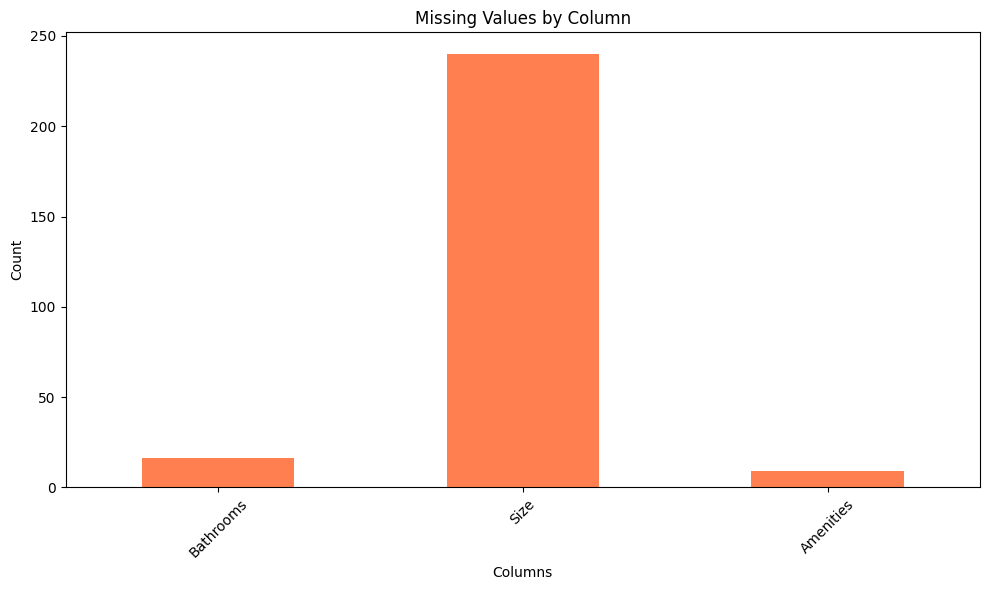

In [4]:
# Check missing values
print("Missing Values Analysis:")
print("=" * 50)
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_df)
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Visualize missing data
plt.figure(figsize=(10, 6))
missing_data = df.isnull().sum()[df.isnull().sum() > 0]
missing_data.plot(kind='bar', color='coral')
plt.title('Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Handle missing values
print("Handling Missing Values:")
print("=" * 50)

# Create a copy to work with
df_clean = df.copy()

# For Size column - it has many missing values, we'll create a flag for it
df_clean['Size_Missing'] = df_clean['Size'].isnull().astype(int)

# Extract numeric values from Size column (remove " m²")
df_clean['Size_Numeric'] = df_clean['Size'].str.replace(' m²', '').str.replace(',', '')
df_clean['Size_Numeric'] = pd.to_numeric(df_clean['Size_Numeric'], errors='coerce')

# For missing sizes, we'll fill with median based on bedrooms
print("\nFilling Size based on bedroom count...")
for bedroom in df_clean['Bedrooms'].unique():
    mask = (df_clean['Bedrooms'] == bedroom) & (df_clean['Size_Numeric'].isnull())
    if mask.sum() > 0:
        median_size = df_clean[df_clean['Bedrooms'] == bedroom]['Size_Numeric'].median()
        if pd.notna(median_size):
            df_clean.loc[mask, 'Size_Numeric'] = median_size

# Fill remaining missing sizes with overall median
overall_median = df_clean['Size_Numeric'].median()
df_clean['Size_Numeric'].fillna(overall_median, inplace=True)

# Clean Bedrooms column - extract numeric value
df_clean['Bedrooms_Numeric'] = df_clean['Bedrooms'].str.extract('(\d+)').astype(int)

print(f"\nMissing values after handling:")
print(df_clean[['Size_Missing', 'Size_Numeric', 'Bedrooms_Numeric']].isnull().sum())
print(f"\nData shape: {df_clean.shape}")

Handling Missing Values:

Filling Size based on bedroom count...

Missing values after handling:
Size_Missing        0
Size_Numeric        0
Bedrooms_Numeric    0
dtype: int64

Data shape: (502, 11)


## 4. Duplicate Removal

In [6]:
# Check and remove duplicates
print("Duplicate Analysis:")
print("=" * 50)
print(f"Total rows before: {len(df_clean)}")
print(f"Duplicate rows: {df_clean.duplicated().sum()}")

# Check duplicates based on key columns
key_columns = ['Location', 'Property Type', 'Bedrooms_Numeric', 'Bathrooms', 'Price (KES)']
print(f"Duplicates based on key columns: {df_clean.duplicated(subset=key_columns).sum()}")

# Remove exact duplicates
df_clean = df_clean.drop_duplicates()

print(f"\nTotal rows after removing duplicates: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

Duplicate Analysis:
Total rows before: 502
Duplicate rows: 14
Duplicates based on key columns: 122

Total rows after removing duplicates: 488
Rows removed: 14


## 5. Outlier Detection and Treatment

Outlier Detection:


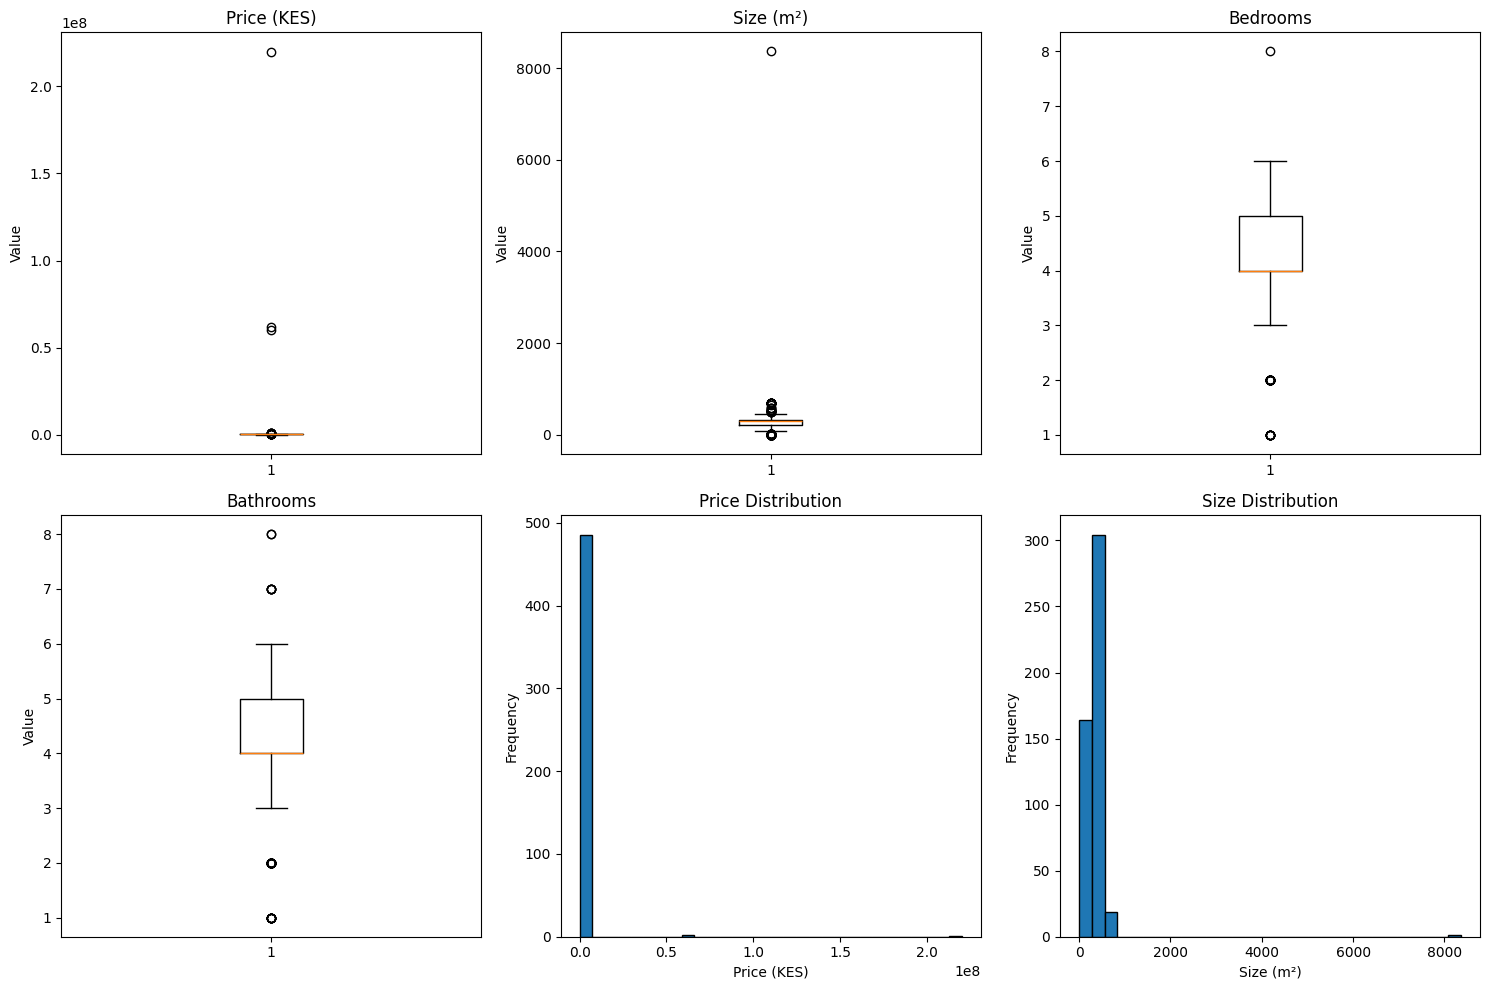


Statistical Summary:
        Price (KES)  Size_Numeric  Bedrooms_Numeric   Bathrooms
count  4.880000e+02    488.000000        488.000000  473.000000
mean   1.079024e+06    289.457689          4.239754    4.355180
std    1.066188e+07    399.438729          1.018261    1.272534
min    3.700000e+04      1.011000          1.000000    1.000000
25%    2.700000e+05    211.250000          4.000000    4.000000
50%    3.800000e+05    300.000000          4.000000    4.000000
75%    4.500000e+05    320.000000          5.000000    5.000000
max    2.200000e+08   8361.000000          8.000000    8.000000


In [7]:
# Identify outliers
print("Outlier Detection:")
print("=" * 50)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Price distribution
axes[0, 0].boxplot(df_clean['Price (KES)'])
axes[0, 0].set_title('Price (KES)')
axes[0, 0].set_ylabel('Value')

# Size distribution
axes[0, 1].boxplot(df_clean['Size_Numeric'])
axes[0, 1].set_title('Size (m²)')
axes[0, 1].set_ylabel('Value')

# Bedrooms distribution
axes[0, 2].boxplot(df_clean['Bedrooms_Numeric'])
axes[0, 2].set_title('Bedrooms')
axes[0, 2].set_ylabel('Value')

# Bathrooms distribution
axes[1, 0].boxplot(df_clean['Bathrooms'].dropna())
axes[1, 0].set_title('Bathrooms')
axes[1, 0].set_ylabel('Value')

# Price histogram
axes[1, 1].hist(df_clean['Price (KES)'], bins=30, edgecolor='black')
axes[1, 1].set_title('Price Distribution')
axes[1, 1].set_xlabel('Price (KES)')
axes[1, 1].set_ylabel('Frequency')

# Size histogram
axes[1, 2].hist(df_clean['Size_Numeric'], bins=30, edgecolor='black')
axes[1, 2].set_title('Size Distribution')
axes[1, 2].set_xlabel('Size (m²)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary:")
print(df_clean[['Price (KES)', 'Size_Numeric', 'Bedrooms_Numeric', 'Bathrooms']].describe())

In [8]:
# Handle outliers using IQR method
print("Handling Outliers:")
print("=" * 50)

def remove_outliers_iqr(df, column, multiplier=1.5):
    """Remove outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"\n{column}:")
    print(f"  Lower bound: {lower_bound:.2f}")
    print(f"  Upper bound: {upper_bound:.2f}")
    print(f"  Outliers found: {len(outliers)}")
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Before outlier removal
print(f"Rows before outlier removal: {len(df_clean)}")

# Remove outliers for Price
df_clean = remove_outliers_iqr(df_clean, 'Price (KES)', multiplier=2.0)

# Remove outliers for Size (less aggressive)
df_clean = remove_outliers_iqr(df_clean, 'Size_Numeric', multiplier=2.5)

# Fill missing bathrooms with median
df_clean['Bathrooms'].fillna(df_clean['Bathrooms'].median(), inplace=True)

print(f"\nRows after outlier removal: {len(df_clean)}")
print(f"Rows removed: {488 - len(df_clean)}")

Handling Outliers:
Rows before outlier removal: 488

Price (KES):
  Lower bound: -90000.00
  Upper bound: 810000.00
  Outliers found: 8

Size_Numeric:
  Lower bound: -33.50
  Upper bound: 572.50
  Outliers found: 20

Rows after outlier removal: 460
Rows removed: 28


## 6. Feature Encoding

In [9]:
# Encode categorical variables
print("Categorical Feature Encoding:")
print("=" * 50)

# Extract neighborhood from Location (after "Nairobi - ")
df_clean['Neighborhood'] = df_clean['Location'].str.replace('Nairobi - ', '')

# Property Type is already simple (House/Apartment), convert to binary
df_clean['Property_Type_Encoded'] = df_clean['Property Type'].map({'House': 1, 'Apartment': 0})
df_clean['Property_Type_Encoded'].fillna(1, inplace=True)  # Default to House if missing

# Parse listing date to datetime
df_clean['Listing_Date'] = pd.to_datetime(df_clean['Listing Date'], format='%d %B %Y')

# Extract day of week and month
df_clean['Listing_Day'] = df_clean['Listing_Date'].dt.day
df_clean['Listing_Month'] = df_clean['Listing_Date'].dt.month
df_clean['Listing_DayOfWeek'] = df_clean['Listing_Date'].dt.dayofweek

# Handle Amenities - count total amenities
df_clean['Amenities_Clean'] = df_clean['Amenities'].fillna('')
df_clean['Total_Amenities'] = df_clean['Amenities_Clean'].apply(lambda x: len(x.split(',')) if x else 0)

# Create binary flags for key amenities
key_amenities = ['Parking', 'Swimming Pool', 'Gym', 'Garden', 'CCTV', 
                 'Backup Generator', 'Fibre Internet', 'Gated Community']

for amenity in key_amenities:
    col_name = f'Has_{amenity.replace(" ", "_")}'
    df_clean[col_name] = df_clean['Amenities_Clean'].str.contains(amenity, case=False, na=False).astype(int)

print(f"\nEncoded columns added:")
print(f"  - Neighborhood (extracted from Location)")
print(f"  - Property_Type_Encoded (binary)")
print(f"  - Listing date features (day, month, day of week)")
print(f"  - Total_Amenities (count)")
print(f"  - Binary flags for {len(key_amenities)} key amenities")

print(f"\nSample of encoded features:")
print(df_clean[['Neighborhood', 'Property_Type_Encoded', 'Total_Amenities', 
                'Has_Parking', 'Has_Swimming_Pool']].head())

Categorical Feature Encoding:

Encoded columns added:
  - Neighborhood (extracted from Location)
  - Property_Type_Encoded (binary)
  - Listing date features (day, month, day of week)
  - Total_Amenities (count)
  - Binary flags for 8 key amenities

Sample of encoded features:
  Neighborhood  Property_Type_Encoded  Total_Amenities  Has_Parking  \
0    Lavington                      1               20            1   
1  Karen Hardy                      1               24            1   
2     Kitisuru                      1               24            1   
3    Lavington                      1               20            1   
4        Runda                      1               14            1   

   Has_Swimming_Pool  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0  


## 7. Feature Engineering

In [10]:
# Create new features
print("Feature Engineering:")
print("=" * 50)

# 1. Price per square meter
df_clean['Price_Per_SqM'] = df_clean['Price (KES)'] / df_clean['Size_Numeric']

# 2. Rooms ratio (bedrooms to bathrooms)
df_clean['Bed_Bath_Ratio'] = df_clean['Bedrooms_Numeric'] / df_clean['Bathrooms']

# 3. Total rooms
df_clean['Total_Rooms'] = df_clean['Bedrooms_Numeric'] + df_clean['Bathrooms']

# 4. Size per bedroom
df_clean['Size_Per_Bedroom'] = df_clean['Size_Numeric'] / df_clean['Bedrooms_Numeric']

# 5. Luxury score (combination of amenities and features)
df_clean['Luxury_Score'] = (
    df_clean['Has_Swimming_Pool'] * 3 +
    df_clean['Has_Gym'] * 2 +
    df_clean['Has_Backup_Generator'] * 1.5 +
    df_clean['Has_Gated_Community'] * 1 +
    df_clean['Has_CCTV'] * 1 +
    df_clean['Has_Fibre_Internet'] * 0.5
)

# 6. Property size category
df_clean['Size_Category'] = pd.cut(df_clean['Size_Numeric'], 
                                     bins=[0, 200, 300, 400, float('inf')],
                                     labels=['Small', 'Medium', 'Large', 'Very Large'])

# 7. Price category
df_clean['Price_Category'] = pd.cut(df_clean['Price (KES)'],
                                      bins=[0, 250000, 400000, 600000, float('inf')],
                                      labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'])

# 8. Bedroom category
df_clean['Bedroom_Category'] = df_clean['Bedrooms_Numeric'].apply(
    lambda x: 'Small' if x <= 2 else ('Medium' if x <= 4 else 'Large')
)

# 9. Neighborhood popularity (frequency encoding)
neighborhood_counts = df_clean['Neighborhood'].value_counts()
df_clean['Neighborhood_Popularity'] = df_clean['Neighborhood'].map(neighborhood_counts)

# 10. Weekend listing flag
df_clean['Is_Weekend_Listing'] = df_clean['Listing_DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

print(f"\nNew features created:")
print(f"  1. Price_Per_SqM")
print(f"  2. Bed_Bath_Ratio")
print(f"  3. Total_Rooms")
print(f"  4. Size_Per_Bedroom")
print(f"  5. Luxury_Score")
print(f"  6. Size_Category")
print(f"  7. Price_Category")
print(f"  8. Bedroom_Category")
print(f"  9. Neighborhood_Popularity")
print(f"  10. Is_Weekend_Listing")

print(f"\nSample of engineered features:")
print(df_clean[['Price_Per_SqM', 'Bed_Bath_Ratio', 'Total_Rooms', 
                'Luxury_Score', 'Size_Category']].head())

print(f"\nFeature Statistics:")
print(df_clean[['Price_Per_SqM', 'Bed_Bath_Ratio', 'Total_Rooms', 'Luxury_Score']].describe())

Feature Engineering:



New features created:
  1. Price_Per_SqM
  2. Bed_Bath_Ratio
  3. Total_Rooms
  4. Size_Per_Bedroom
  5. Luxury_Score
  6. Size_Category
  7. Price_Category
  8. Bedroom_Category
  9. Neighborhood_Popularity
  10. Is_Weekend_Listing

Sample of engineered features:
   Price_Per_SqM  Bed_Bath_Ratio  Total_Rooms  Luxury_Score Size_Category
0    2343.750000        0.714286         12.0           8.5         Large
1    1589.958159        1.000000          6.0           4.0        Medium
2    1666.666667        1.000000          8.0           4.0        Medium
3    1166.666667        1.000000          8.0           4.0        Medium
4    1202.222222        1.000000         10.0           2.0    Very Large

Feature Statistics:
       Price_Per_SqM  Bed_Bath_Ratio  Total_Rooms  Luxury_Score
count     460.000000      460.000000   460.000000    460.000000
mean    19153.048897        1.014563     8.480435      3.390217
std     50629.057998        0.247632     2.185725      2.223467
min       123

## 8. Data Validation

In [11]:
# Validate cleaned data
print("Data Validation:")
print("=" * 50)

# Check for missing values in key columns
print("\nMissing values in processed data:")
missing_summary = df_clean.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("No missing values in numeric/critical columns!")

# Data type validation
print(f"\nData shape: {df_clean.shape}")
print(f"Total features: {len(df_clean.columns)}")

# Check data ranges
print("\nData range validation:")
print(f"  Price range: {df_clean['Price (KES)'].min():,.0f} - {df_clean['Price (KES)'].max():,.0f} KES")
print(f"  Size range: {df_clean['Size_Numeric'].min():.0f} - {df_clean['Size_Numeric'].max():.0f} m²")
print(f"  Bedrooms range: {df_clean['Bedrooms_Numeric'].min()} - {df_clean['Bedrooms_Numeric'].max()}")
print(f"  Bathrooms range: {df_clean['Bathrooms'].min():.0f} - {df_clean['Bathrooms'].max():.0f}")

# Check for duplicates
print(f"\nDuplicate check: {df_clean.duplicated().sum()} duplicates found")

# Distribution of key features
print("\nKey feature distributions:")
print("\nProperty Types:")
print(df_clean['Property Type'].value_counts())

print("\nPrice Categories:")
print(df_clean['Price_Category'].value_counts())

print("\nTop 5 Neighborhoods:")
print(df_clean['Neighborhood'].value_counts().head())

print("\n Data validation complete!")

Data Validation:

Missing values in processed data:
Size         232
Amenities      9
dtype: int64

Data shape: (460, 37)
Total features: 37

Data range validation:
  Price range: 37,000 - 780,000 KES
  Size range: 1 - 546 m²
  Bedrooms range: 1 - 8
  Bathrooms range: 1 - 8

Duplicate check: 0 duplicates found

Key feature distributions:

Property Types:
Property Type
House    460
Name: count, dtype: int64

Price Categories:
Price_Category
Mid-Range    177
Premium      129
Budget       112
Luxury        42
Name: count, dtype: int64

Top 5 Neighborhoods:
Neighborhood
Lavington    102
Runda         85
Karen         45
Kitisuru      27
Nyari         20
Name: count, dtype: int64

 Data validation complete!


## 9. Save Processed Data

In [12]:
# Save to processed folder
import os

# Create processed directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save the cleaned data
output_path = '../data/processed/cleaned_listings.csv'
df_clean.to_csv(output_path, index=False)

print(f"✓ Processed data saved to: {output_path}")
print(f"  Rows: {len(df_clean)}")
print(f"  Columns: {len(df_clean.columns)}")

# Also save a feature list for reference
feature_columns = df_clean.columns.tolist()
print(f"\nAll columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

✓ Processed data saved to: ../data/processed/cleaned_listings.csv
  Rows: 460
  Columns: 37

All columns (37):
  1. Location
  2. Property Type
  3. Bedrooms
  4. Bathrooms
  5. Size
  6. Price (KES)
  7. Listing Date
  8. Amenities
  9. Size_Missing
  10. Size_Numeric
  11. Bedrooms_Numeric
  12. Neighborhood
  13. Property_Type_Encoded
  14. Listing_Date
  15. Listing_Day
  16. Listing_Month
  17. Listing_DayOfWeek
  18. Amenities_Clean
  19. Total_Amenities
  20. Has_Parking
  21. Has_Swimming_Pool
  22. Has_Gym
  23. Has_Garden
  24. Has_CCTV
  25. Has_Backup_Generator
  26. Has_Fibre_Internet
  27. Has_Gated_Community
  28. Price_Per_SqM
  29. Bed_Bath_Ratio
  30. Total_Rooms
  31. Size_Per_Bedroom
  32. Luxury_Score
  33. Size_Category
  34. Price_Category
  35. Bedroom_Category
  36. Neighborhood_Popularity
  37. Is_Weekend_Listing


## Summary

### Data Quality Improvements
- **Original data**: 502 rows, 8 columns
- **Cleaned data**: 460 rows, 37 columns
- **Rows removed**: 42 (14 duplicates + 28 outliers)
- **Missing values handled**: 
  - Size: 240 missing values filled using bedroom-based median imputation
  - Bathrooms: 16 missing values filled with median
  - Amenities: 9 missing values handled
- **Data quality**: No duplicates, outliers removed using IQR method

### Features Created
1. **Numeric Features**:
   - Size_Numeric (cleaned from Size)
   - Bedrooms_Numeric (extracted from text)
   - Price_Per_SqM
   - Bed_Bath_Ratio
   - Total_Rooms
   - Size_Per_Bedroom
   - Luxury_Score

2. **Categorical Features**:
   - Neighborhood (extracted from Location)
   - Property_Type_Encoded (binary)
   - Size_Category (Small/Medium/Large/Very Large)
   - Price_Category (Budget/Mid-Range/Premium/Luxury)
   - Bedroom_Category (Small/Medium/Large)

3. **Time Features**:
   - Listing_Day, Listing_Month, Listing_DayOfWeek
   - Is_Weekend_Listing (binary flag)

4. **Amenity Features**:
   - Total_Amenities (count)
   - 8 binary flags for key amenities (Parking, Swimming Pool, Gym, Garden, CCTV, Backup Generator, Fibre Internet, Gated Community)

5. **Derived Features**:
   - Neighborhood_Popularity (frequency encoding)
   - Size_Missing (indicator flag)

### Next Steps
- **Day 3**: Exploratory Data Analysis (EDA) and baseline model development
- Analyze feature correlations with price
- Build and evaluate baseline machine learning models
- Feature importance analysis

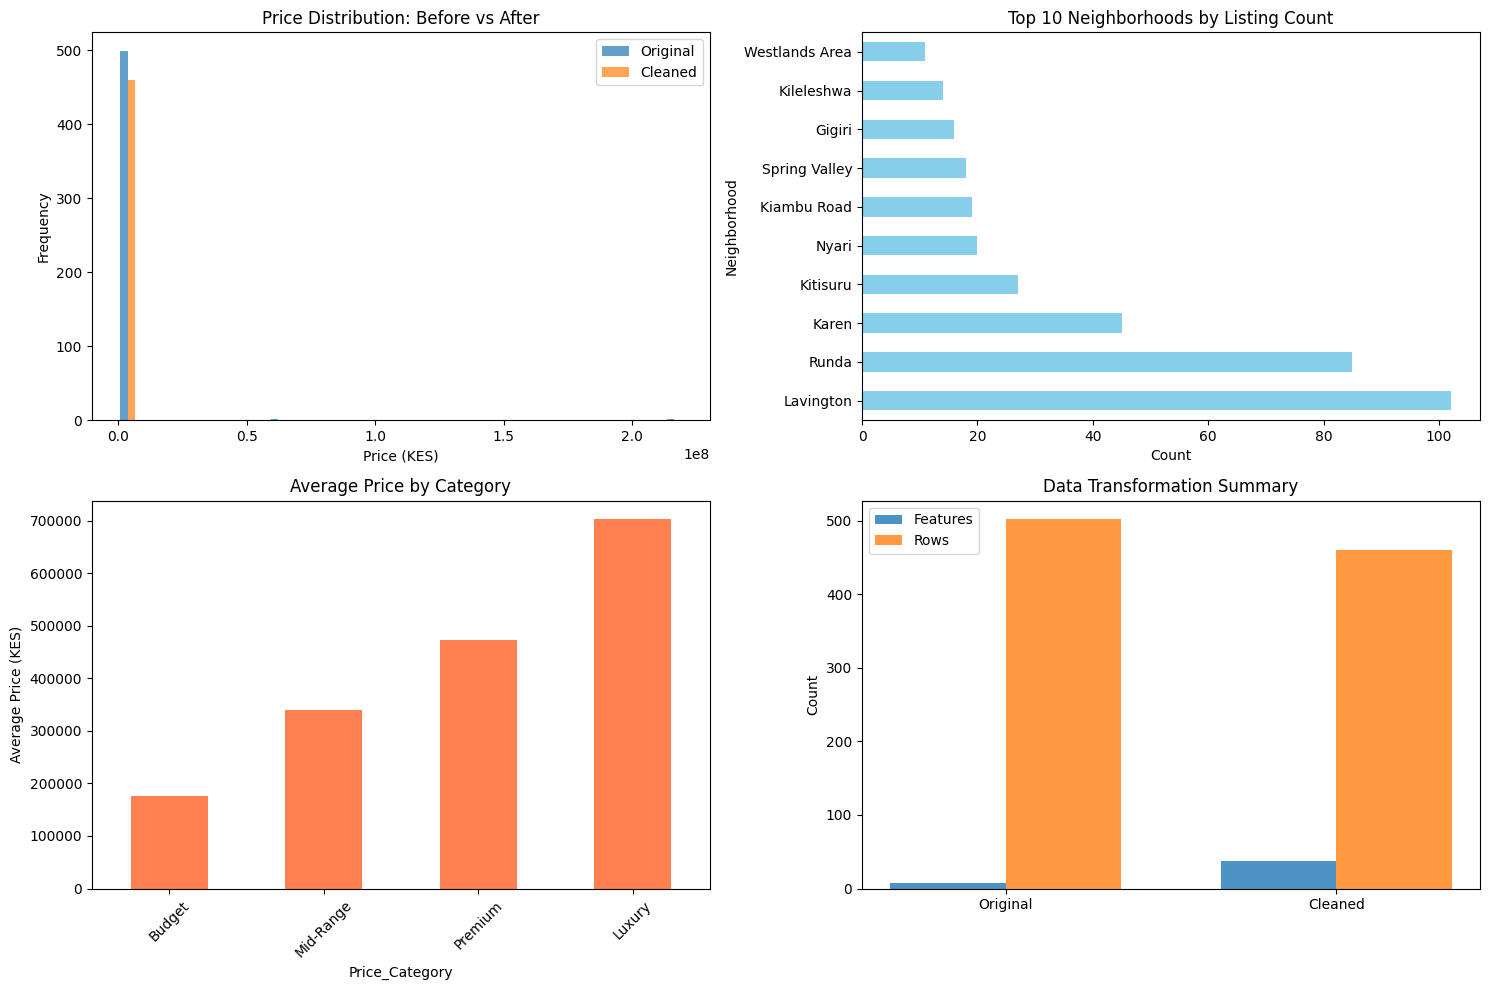

 Cleaned data saved to: data/processed/cleaned_listings.csv
 Ready for EDA and Baseline Modeling


In [13]:
# Final summary visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Price distribution comparison
axes[0, 0].hist([df['Price (KES)'], df_clean['Price (KES)']], 
                label=['Original', 'Cleaned'], bins=30, alpha=0.7)
axes[0, 0].set_title('Price Distribution: Before vs After')
axes[0, 0].set_xlabel('Price (KES)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# 2. Top neighborhoods
top_neighborhoods = df_clean['Neighborhood'].value_counts().head(10)
top_neighborhoods.plot(kind='barh', ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Top 10 Neighborhoods by Listing Count')
axes[0, 1].set_xlabel('Count')

# 3. Price by category
df_clean.groupby('Price_Category')['Price (KES)'].mean().plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Average Price by Category')
axes[1, 0].set_ylabel('Average Price (KES)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# 4. Feature count comparison
feature_counts = pd.DataFrame({
    'Stage': ['Original', 'Cleaned'],
    'Features': [len(df.columns), len(df_clean.columns)],
    'Rows': [len(df), len(df_clean)]
})
x = np.arange(len(feature_counts))
width = 0.35
axes[1, 1].bar(x - width/2, feature_counts['Features'], width, label='Features', alpha=0.8)
axes[1, 1].bar(x + width/2, feature_counts['Rows'], width, label='Rows', alpha=0.8)
axes[1, 1].set_title('Data Transformation Summary')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(feature_counts['Stage'])
axes[1, 1].legend()
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f" Cleaned data saved to: data/processed/cleaned_listings.csv")
print(f" Ready for EDA and Baseline Modeling")